## Efficient Graph Based Image Segmentation

In [1]:
from random import random
from PIL import Image, ImageFilter
from skimage import io
import numpy as np
from matplotlib import pyplot as plt
from copy import deepcopy

**Hyperparameters**
1. Sigma
2. k
3. Minimum Component Size

In [2]:
class Node:
    def __init__(self, parent):
        self.rank = 0
        self.size = 1
        self.parent = parent

In [3]:
class Graph:
    def __init__(self, img, height, width):
        self.img = img #np.swapaxes(img, 0, 1)
        self.edges = []
        self.height, self.width = height, width
        self.vertexId = lambda x, y: y * self.width + x
    
    def measureDissimilarity(self, x1, y1, x2, y2):
        return np.sqrt(np.sum((self.img[y1, x1] - self.img[y2, x2])**2))
    
    def createEdge(self, x1, y1, x2, y2):
        weight = self.measureDissimilarity(x1, y1, x2, y2)
        return np.array([self.vertexId(x1, y1), self.vertexId(x2, y2), weight])
        
    def build(self):
        for y in range(self.height):
            for x in range(self.width):
                if x < self.width - 1:
                    self.edges.append(self.createEdge(x, y, x+1, y))
                if y < self.height - 1:
                    self.edges.append(self.createEdge(x, y, x, y+1))
                if (x < self.width - 1) and (y < self.height - 1):
                    self.edges.append(self.createEdge(x, y, x+1, y+1))
                if (x < self.width - 1) and (y > 0):
                    self.edges.append(self.createEdge(x, y, x+1, y-1))
        self.edges = np.array(self.edges)

In [4]:
class Forest:
    def __init__(self, nElements):
        self.nSets = nElements
        self.nNodes = []
        for i in range(self.nSets):
            self.nNodes.append(Node(i))
    
    def find(self, x):
        y = int(x)
        #print(x, y)
        while y != self.nNodes[y].parent:
            y = self.nNodes[y].parent
        self.nNodes[int(x)].parent = y
        return y
    
    def join(self, x, y):
        x, y = int(x), int(y)
        if self.nNodes[x].rank > self.nNodes[y].rank:
            self.nNodes[y].parent = x
            self.nNodes[x].size += self.nNodes[y].size
        else:
            self.nNodes[x].parent = y
            self.nNodes[y].size += self.nNodes[x].size
            if self.nNodes[x].rank == self.nNodes[y].rank:
                self.nNodes[x].rank += 1
        self.nSets -= 1
        
    def sizeOfComponent(self, x):
        return self.nNodes[x].size
    
    def numOfComponents(self):
        return self.nSets

In [5]:
class SegmentedGraph:
    def __init__(self, G, k, minComSize):
        self.height, self.width = G.height, G.width
        self.edges = deepcopy(G.edges)
        self.nVertices = G.height * G.width
        self.nEdges = G.edges.shape[0]
        self.edges[0: self.nEdges, :] = self.edges[self.edges[0:self.nEdges, 2].argsort()]
        self.k, self.minComponentSize = k, minComSize
        self.forest = None
        self.threshold = np.zeros((self.nVertices))
        #print(self.nEdges, self.nVertices, self.nVertices*4)
        
    def buildForest(self):
        self.forest = Forest(self.nVertices)
        for i in range(self.nVertices):
            self.threshold[i] = self.getThreshold(self.forest.nNodes[i].size)
        
    def getThreshold(self, cSize):
        return self.k / cSize
    
    def build(self):
        self.buildForest()
        for i in range(self.nEdges):
            edge = self.edges[i]
            weight = edge[2]
            a, b = self.forest.find(edge[0]), self.forest.find(edge[1])
            if a != b:
                if (weight <= self.threshold[a]) and (weight <= self.threshold[b]):
                    self.forest.join(a, b)
                    a = self.forest.find(a)
                    self.threshold[a] = weight + self.getThreshold(self.forest.sizeOfComponent(a))
        for i in range(self.nEdges):
            edge = self.edges[i]
            a, b = self.forest.find(edge[0]), self.forest.find(edge[1])
            if (a != b) and ((self.forest.sizeOfComponent(a) < self.minComponentSize) or (self.forest.sizeOfComponent(b) < self.minComponentSize)):
                self.forest.join(a, b)
        return deepcopy(self.forest)

In [6]:
class SegmentImage:
    def __init__(self, imgPath, sigma, k, minComSize):
        self.imgPath, self.sigma = imgPath, sigma
        self.k, self.minComponentSize = k, minComSize
        self.img, self.width, self.height = None, None, None
        self.blurredImage = None
        self.forest = None
        self.outputImg, self.nChannels = None, None
        
    def getImage(self):
        self.img = Image.open(self.imgPath)
        self.width, self.height = self.img.size
    
    def smoothingWithGaussianFilter(self): #blurred image
        self.blurredImage = np.array(self.img.filter(ImageFilter.GaussianBlur(self.sigma)), dtype = 'int')
        self.outputImg = np.zeros(self.blurredImage.shape, dtype='int')
        try: self.nChannels = self.outputImg.shape[2]
        except: self.nChannels = 1
        
    def build(self):
        self.getImage()
        self.smoothingWithGaussianFilter()
        G = Graph(self.blurredImage, self.height, self.width)
        G.build()
        segmentedGraph = SegmentedGraph(G, self.k, self.minComponentSize)
        self.forest = segmentedGraph.build()
        del segmentedGraph
        colors = np.random.randint(0, 256, (G.height * G.width, self.nChannels), dtype='int')
        for y in range(G.height):
            for x in range(G.width):
                head = self.forest.find(y * G.width + x)
                if self.nChannels == 1: self.outputImg[y, x] = colors[head]
                else: self.outputImg[y, x, : ] = colors[head]
        del G, colors
        return self.img, self.outputImg

In [7]:
def run(imgPath, sigma, k, minComponentSize):
    segImg = SegmentImage(imgPath, sigma, k, minComponentSize)
    img, outputImg = segImg.build()
    del segImg
    fig = plt.figure(figsize=(16, 10))
    a = fig.add_subplot(1, 2, 1)
    plt.imshow(img)
    a.set_title('Original Image')
    a = fig.add_subplot(1, 2, 2)
    plt.imshow(outputImg)
    a.set_title('Segmented Image')
    plt.show()
    del img, outputImg

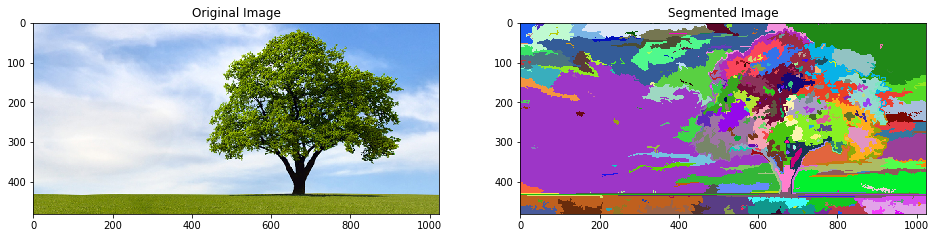

In [68]:
run('Data/BigTree.jpg', 1.5, 500, 50)

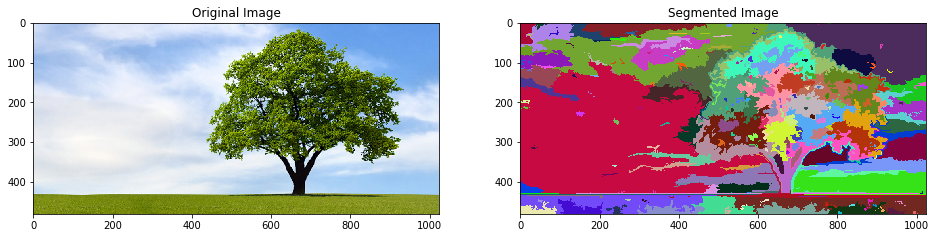

In [70]:
run('Data/BigTree.jpg', 1.5, 800, 50)

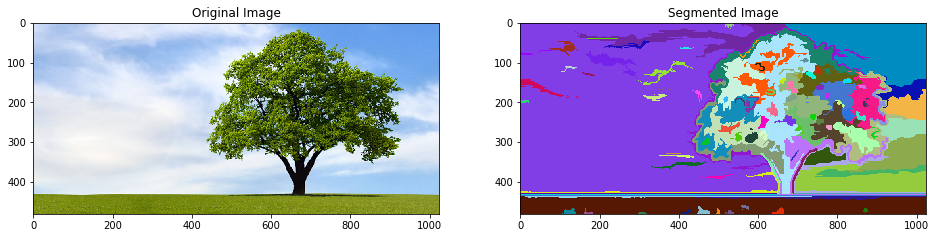

In [72]:
run('Data/BigTree.jpg', 3, 1000, 100)

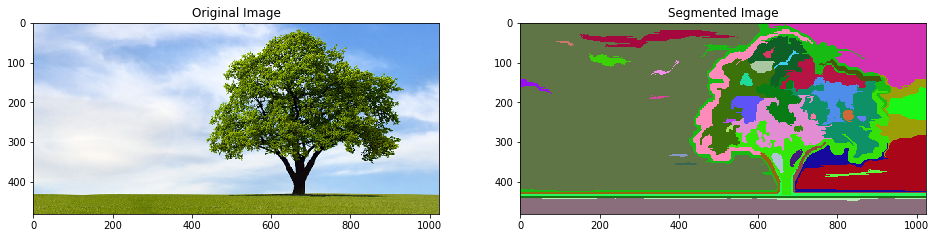

In [74]:
run('Data/BigTree.jpg', 5, 2000, 150)

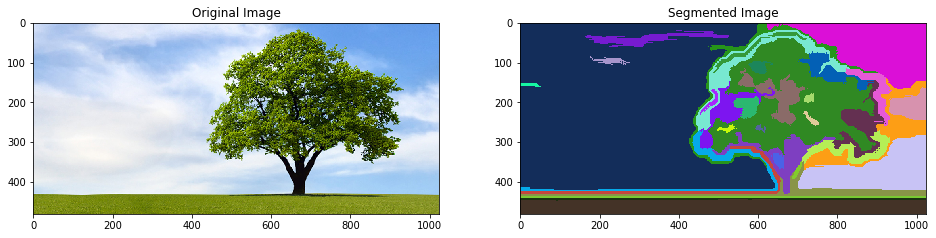

In [76]:
run('Data/BigTree.jpg', 7, 2000, 250)

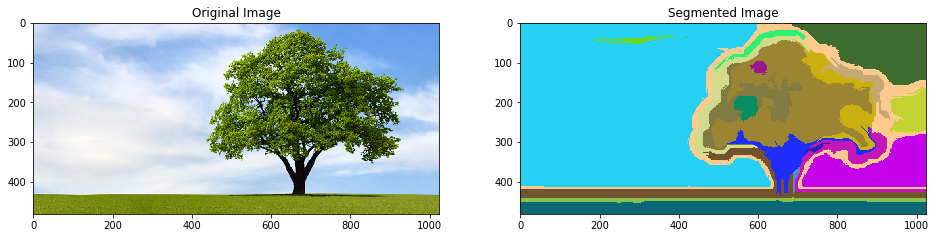

In [85]:
run('Data/BigTree.jpg', 11, 2000, 450)

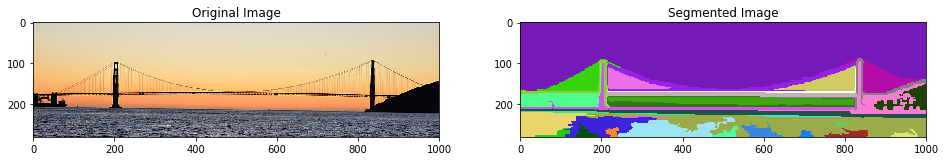

In [87]:
run('Data/bridge.jpg', 3, 1500, 250)

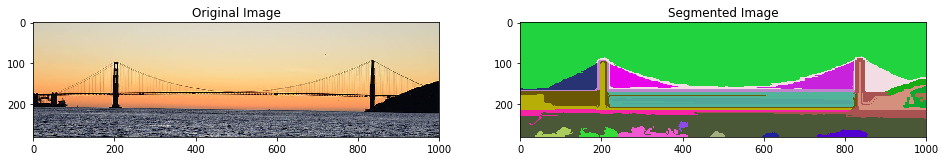

In [93]:
run('Data/bridge.jpg', 5, 1500, 350)

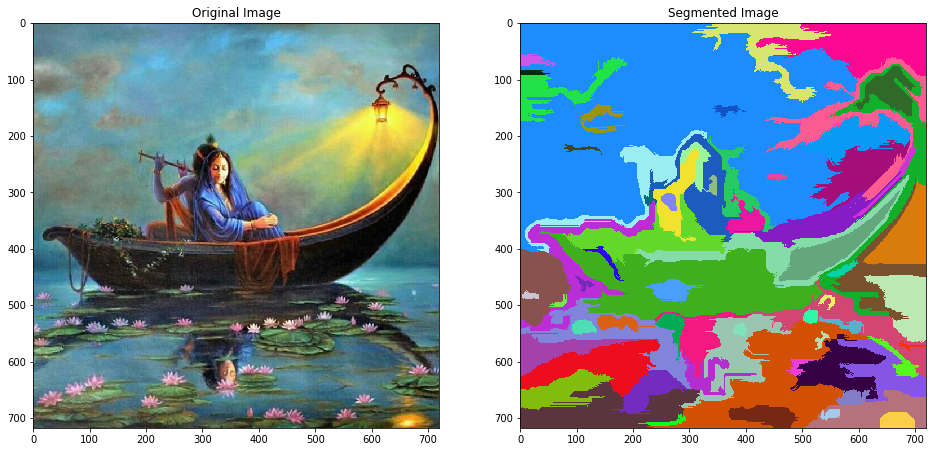

In [95]:
run('Data/krishna.jpg', 7, 1500, 250)

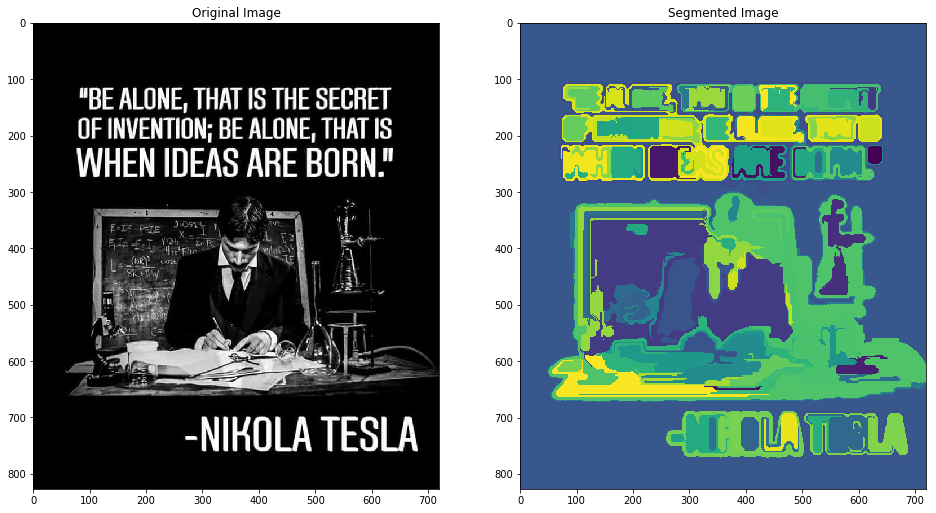

In [97]:
run('Data/tesla_gray.jpg', 4, 1500, 350)

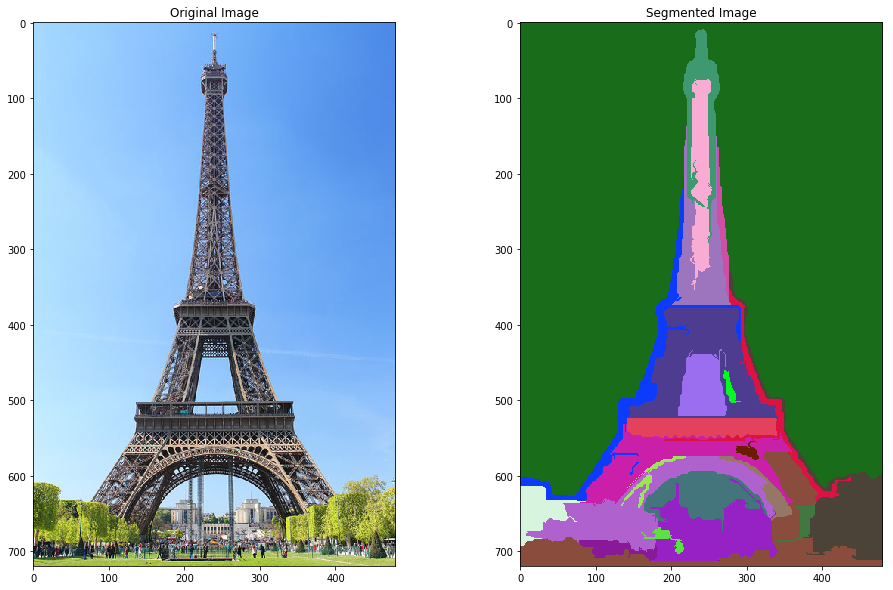

In [9]:
run('Data/paris.jpg', 3, 1700, 350)